# **Phân loại tin tức tiếng Việt sử dụng SVM**

In [4]:
!pip install pyvi
!pip install imbalanced-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.5/8.5 MB 56.0 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 30.5 MB/s eta 0:00:00:00:01


## 1. Xác định bài toán

- Đầu vào bài toán: 1 đoạn tin tức tiếng Việt  
- Đầu ra: Lớp tương ứng với đoạn tin tức đó

- Dataset: VNews8td  
- Mô tả:  Được thu thập từ trang báo mạng VnExpress từ ngày 01/06/2023 - 01/06/2024. Gồm 8 lớp, chia train:val:test theo tỉ lệ 70:10:20. Mỗi văn bản sẽ gồm có tiêu đề và phần mô tả của bài báo  
- 8 lớp: 	
    * doisong (Đời sống)
	* giaoduc (Giáo dục)
	* khoahoc (Khoa học)
	* kinhte (Kinh tế)
	* suckhoe (Sức khỏe)
	* thegioi (Thế giới)
	* thethao (Thể thao)
	* thoisu (Thời sự)

### Import thư viện 

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pyvi import ViTokenizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn import svm
from sklearn.metrics import classification_report
from sklearn.metrics import  ConfusionMatrixDisplay

## 2. Tiền xử lý dữ liệu

In [6]:
train_df = pd.read_csv("/kaggle/input/vnews8td/VNews8td/train.tsv", sep='\t',header=None, names=['văn bản','lớp'])
test_df = pd.read_csv("/kaggle/input/vnews8td/VNews8td/test.tsv", sep='\t',header=None, names=['văn bản','lớp'])
val_df = pd.read_csv("/kaggle/input/vnews8td/VNews8td/val.tsv", sep='\t',header=None, names=['văn bản','lớp'])

In [7]:
print(train_df.shape)
print(test_df.shape)
print(val_df.shape)

(31745, 2)
(9115, 2)
(4490, 2)


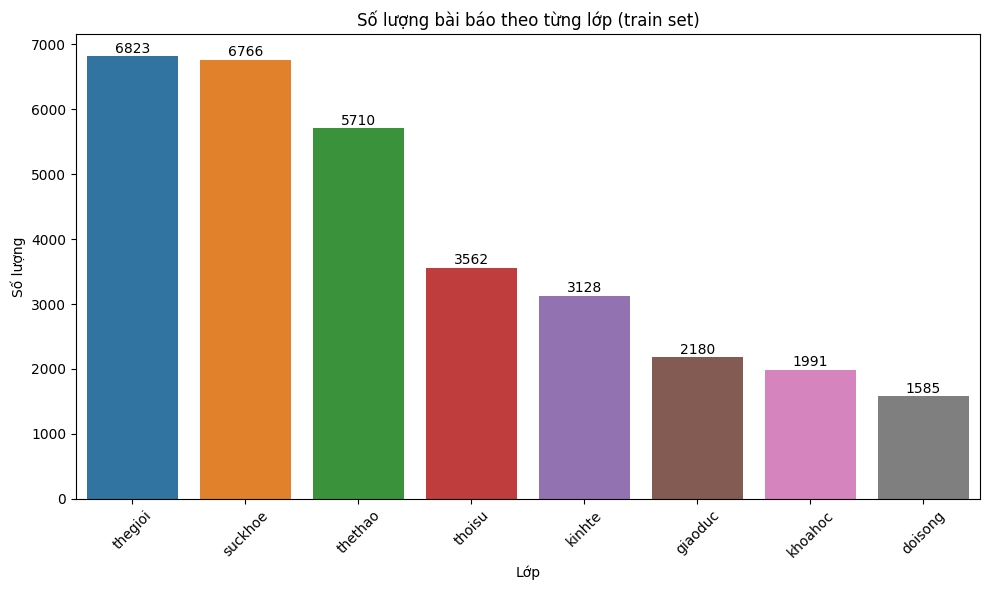

In [8]:
plt.figure(figsize=(10, 6))
ax = sns.countplot(data=train_df, x='lớp', order=train_df['lớp'].value_counts().index)

plt.title('Số lượng bài báo theo từng lớp (train set)')
plt.xlabel('Lớp')
plt.ylabel('Số lượng')
plt.xticks(rotation=45)

for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2, height + 5,  
            f'{int(height)}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

Dữ liệu bị mất cân bằng giữa các lớp --> dùng class weighted, hoặc augment data 

In [9]:
tokens = ViTokenizer.tokenize(train_df['văn bản'][0]).split()
print(tokens)

['Ba_Lan', 'sa_thải', 'HLV', 'Santos', 'sau', 'sáu', 'trận', '.', 'Liên_đoàn', 'Bóng_đá', 'Ba_Lan', 'quyết_định', 'chia_tay', 'HLV', 'Fernando_Santos', ',', 'người', 'từng', 'đưa', 'Bồ_Đào_Nha', 'đến', 'chức', 'vô_địch', 'Euro', '2016', '.']


In [10]:
with open('/kaggle/input/vietnamese-stopwords/vietnamese_stopwords.txt', 'r', encoding='utf-8') as f:
    stopwords = list(line.strip() for line in f)

def preprocess(text):
    tokens = ViTokenizer.tokenize(text).split()
    filtered_tokens = [t for t in tokens if t not in stopwords]
    return ' '.join(filtered_tokens)

txt = preprocess(train_df['văn bản'][0])
print(txt)

Ba_Lan sa_thải HLV Santos sáu trận . Liên_đoàn Bóng_đá Ba_Lan quyết_định chia_tay HLV Fernando_Santos , Bồ_Đào_Nha chức vô_địch Euro 2016 .


In [ ]:
print("Danh sách 10 từ dừng đầu tiên (từ không mang ý nghĩa phân loại): ", stopwords[0:10])

Ghép các từ tiếng Việt lại và xóa stop words 

In [11]:
train_df['processed'] = train_df['văn bản'].apply(preprocess)
val_df['processed'] = val_df['văn bản'].apply(preprocess)
test_df['processed'] = test_df['văn bản'].apply(preprocess)

In [ ]:
train_df['văn bản'][0]

In [ ]:
train_df['processed'][0]

Chuyển dữ liệu từ dạng văn bản về dạng số để xử lý 

In [12]:
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(train_df['processed'])
X_val = vectorizer.transform(val_df['processed'])
X_test = vectorizer.transform(test_df['processed'])


In [13]:
le = LabelEncoder()
y_train = le.fit_transform(train_df['lớp'])
y_val = le.transform(val_df['lớp'])
y_test = le.transform(test_df['lớp'])

In [14]:
labels = le.classes_
print(labels)

['doisong' 'giaoduc' 'khoahoc' 'kinhte' 'suckhoe' 'thegioi' 'thethao'
 'thoisu']


In [ ]:
print("Dữ liệu training: ", X_train.shape, y_train.shape)
print("Dữ liệu validation: ", X_val.shape, y_val.shape)
print("Dữ liệu testing: ", X_test.shape, y_test.shape)

In [ ]:
from sklearn.decomposition import TruncatedSVD
import re

svd = TruncatedSVD(n_components=3, random_state=42)
X_svd = svd.fit_transform(X_train)

plt.figure(figsize=(10, 6))
scatter = plt.scatter(X_svd[:, 0], X_svd[:, 1], c=y_train, cmap='tab10', s=10)

handles, indices = scatter.legend_elements()

legend_labels = [labels[int(re.sub(r"[^\d]", "", i))] for i in indices]
plt.legend(handles, legend_labels, title="Lớp")

plt.title("Trực quan hóa các lớp văn bản")
plt.xlabel("Thành phần 1")
plt.ylabel("Thành phần 2")
plt.grid(True)
plt.tight_layout()
plt.show()

## 3. Huấn luyện mô hình & đánh giá mô hình

*Lưu ý: Đánh giá trên tập validation*

### Kernel linear với C=1

In [ ]:
print("- Training with kernel linear ...")
print("- Train size = {}".format(X_train.shape))
model_linear = svm.SVC(kernel='linear', C=1, class_weight="balanced")
model_linear.fit(X_train, y_train)
print("- model - train complete")


In [ ]:
from sklearn.metrics import confusion_matrix

print("- Testing ...")
y_val_pred = model_linear.predict(X_val)
y_train_pred = model_linear.predict(X_train)
print("\n Classification Report (Train Set):")
print(classification_report(y_train, y_train_pred, target_names=le.classes_))

In [ ]:
print("\n Classification Report (Validation Set):")
print(classification_report(y_val, y_val_pred, target_names=le.classes_))

In [ ]:
print("\n Confusion Matrix (Validation Set):")
cm_val_linear = confusion_matrix(y_val, y_val_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_val_linear, display_labels=labels)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix - SVM - Linear kernel")


### Kernel rbf với C=1

In [ ]:
print("- Training with kernel rbf ...")
print("- Train size = {}".format(X_train.shape))
model_rbf = svm.SVC(kernel='rbf', C=1, class_weight="balanced")
model_rbf.fit(X_train, y_train)
print("- model - train complete")

In [ ]:
print("- Testing with kernel rbf ...")
y_val_pred = model_rbf.predict(X_val)

print("\n Classification Report (Train Set):")
print(classification_report(y_train, y_train_pred, target_names=le.classes_))

In [ ]:
print("\nClassification Report (Validation Set):")
print(classification_report(y_val, y_val_pred, target_names=le.classes_))

In [ ]:
print("\n Confusion Matrix (Validation Set):")
cm_val_rbf = confusion_matrix(y_val, y_val_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_val_rbf, display_labels=labels)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix - SVM - RBF kernel")

### Kernel poly với C=1

In [ ]:
print("- Training with kernel poly ...")
print("- Train size = {}".format(X_train.shape))
model_poly = svm.SVC(kernel='poly', C=1, class_weight="balanced")
model_poly.fit(X_train, y_train)
print("- model - train complete")

In [ ]:
print("- Testing with kernel poly ...")
y_val_pred = model_poly.predict(X_val)
print("\n Classification Report (Train Set):")
print(classification_report(y_train, y_train_pred, target_names=le.classes_))

In [ ]:
print("\nClassification Report (Validation Set):")
print(classification_report(y_val, y_val_pred, target_names=le.classes_))

In [ ]:
print("\n Confusion Matrix (Validation Set):")
cm_val_poly = confusion_matrix(y_val, y_val_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_val_poly, display_labels=labels)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix - SVM - polypoly kernel")

### Kernel sigmoid với C=1

In [ ]:
print("- Training with kernel sigmoid ...")
print("- Train size = {}".format(X_train.shape))
model_sigmoid = svm.SVC(kernel='sigmoid', C=1, class_weight="balanced")
model_sigmoid.fit(X_train, y_train)
print("- model - train complete")


In [ ]:
print("- Testing with kernel sigmoid ...")
y_val_pred = model_sigmoid.predict(X_val)
print("\n Classification Report (Train Set):")
print(classification_report(y_train, y_train_pred, target_names=le.classes_))

In [ ]:
print("\nClassification Report (Validation Set):")
print(classification_report(y_val, y_val_pred, target_names=le.classes_))

In [ ]:
print("\n Confusion Matrix (Validation Set):")
cm_val_sigmoid = confusion_matrix(y_val, y_val_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_val_poly, display_labels=labels)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix - SVM - Sigmoid kernel")

### Thực hiện sử dụng model đã được train để infer 1 văn bản mới 

In [ ]:
new_doc = "nhập môn trí tuệ nhân tạo"
#Xóa stopwords
new_doc = preprocess(new_doc)
print([new_doc])

input_data_preprocessed = vectorizer.transform([new_doc])
print(input_data_preprocessed)

### Dự đoán nhãn của văn bản trên

In [ ]:
prediction = model_rbf.predict(input_data_preprocessed)
predicted_label = prediction[0]
predicted_category = le.inverse_transform([predicted_label])[0]
print(f"Predicted label index: {predicted_label}")
print(f"Predicted category: {predicted_category}")

## 4. Tối ưu tham số

*Lưu ý: tối ưu tham số trên tập validation, sau đó cuối cùng lấy tham số tốt nhất đánh giá cho tập test* 

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from scipy.stats import uniform

# Định nghĩa tham số cần tối ưu
param_dist = [
    {'kernel': ['linear'],'C':[0.1,1,5,10]},
    {'kernel': [ 'rbf', 'sigmoid'],'C': [0.01,0.1, 1, 10],'gamma': [0.01,0.1, 1, 10]}
]
  

# Khởi tạo model SVM
svm = SVC(class_weight='balanced')

# Randomized Search với Cross-Validation
random_search = RandomizedSearchCV(
    estimator=svm, 
    param_distributions=param_dist, 
    n_iter=30,  # Số lần thử nghiệm
    scoring='f1_weighted',
    n_jobs=-1, 
    cv=3, 
    verbose=1,
    random_state=42)
random_search.fit(X_train, y_train)

# Kết quả
print("Best Parameters:", random_search.best_params_)
print("Best Cross-Validation F1 Score:", random_search.best_score_)


In [ ]:
# Đánh giá trên tập test
best_model = random_search.best_estimator_
y_test_pred = best_model.predict(X_test)
print("\nTest Set Classification Report:\n", classification_report(y_test, y_test_pred, target_names=labels))

## 5. Cải tiến mô hình

In [1]:
!pip install imbalanced-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 63.7 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
category-encoders 2.7.0 requires scikit-learn<1.6.0,>=1.0.0, but you have scikit-learn 1.6.1 which is incompatible.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.


In [2]:
import sklearn
import imblearn

print(sklearn.__version__)
print(imblearn.__version__)

1.6.1
0.13.0


In [16]:
# 1. Import các thư viện cần thiết
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import BaggingClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform # Đã có sẵn

labels = le.classes_
print("Kích thước dữ liệu huấn luyện gốc:", X_train.shape, y_train.shape)
print("Số lượng mẫu mỗi lớp trong train set gốc:")
for i, label in enumerate(labels):
    print(f"  {label} ({i}): {np.sum(y_train == i)}")

Kích thước dữ liệu huấn luyện gốc: (31745, 30910) (31745,)
Số lượng mẫu mỗi lớp trong train set gốc:
  doisong (0): 1585
  giaoduc (1): 2180
  khoahoc (2): 1991
  kinhte (3): 3128
  suckhoe (4): 6766
  thegioi (5): 6823
  thethao (6): 5710
  thoisu (7): 3562


In [17]:
# 2. Áp dụng SMOTE trên tập huấn luyện
print("\nÁp dụng SMOTE trên tập huấn luyện...")
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print("Kích thước dữ liệu huấn luyện sau SMOTE:", X_train_resampled.shape, y_train_resampled.shape)
print("Số lượng mẫu mỗi lớp trong train set sau SMOTE:")
for i, label in enumerate(labels):
    print(f"  {label} ({i}): {np.sum(y_train_resampled == i)}")


Áp dụng SMOTE trên tập huấn luyện...
Kích thước dữ liệu huấn luyện sau SMOTE: (54584, 30910) (54584,)
Số lượng mẫu mỗi lớp trong train set sau SMOTE:
  doisong (0): 6823
  giaoduc (1): 6823
  khoahoc (2): 6823
  kinhte (3): 6823
  suckhoe (4): 6823
  thegioi (5): 6823
  thethao (6): 6823
  thoisu (7): 6823


In [ ]:
# 3. Tiếp tục quá trình tối ưu và huấn luyện mô hình với dữ liệu đã được SMOTE

# --- Huấn luyện lại SVM tốt nhất (từ RandomizedSearchCV) với dữ liệu SMOTE ---
print("\nHuấn luyện lại SVM tốt nhất (linear C=1) với dữ liệu sau SMOTE...")
# Sử dụng lại tham số tốt nhất đã tìm được từ RandomizedSearchCV
best_svm_after_smote = SVC(kernel='linear', C=1, class_weight='balanced', random_state=42)
best_svm_after_smote.fit(X_train_resampled, y_train_resampled)

In [ ]:
print("\nSVM (sau SMOTE) - Train Set Classification Report:")
y_train_pred_smote = best_svm_after_smote.predict(X_train_resampled)
print(classification_report(y_train_resampled, y_train_pred_smote, target_names=labels))

In [ ]:
print("\nSVM (sau SMOTE) - Validation Set Classification Report:")
y_val_pred_smote = best_svm_after_smote.predict(X_val)
print(classification_report(y_val, y_val_pred_smote, target_names=labels))

In [ ]:
print("\nSVM (sau SMOTE) - Test Set Classification Report:")
y_test_pred_smote = best_svm_after_smote.predict(X_test)
print(classification_report(y_test, y_test_pred_smote, target_names=labels))

In [ ]:
# --- Huấn luyện lại Bagging SVM với dữ liệu sau SMOTE ---
print("\nHuấn luyện lại Bagging SVM với dữ liệu sau SMOTE...")
# Sử dụng lại base_svm đã tối ưu
base_svm_for_bagging_smote = SVC(kernel='linear', C=1, class_weight='balanced', random_state=42)
bagging_svm_smote = BaggingClassifier(
    estimator=base_svm_for_bagging_smote,
    n_estimators=10,
    max_samples=0.8,
    random_state=42
)
bagging_svm_smote.fit(X_train_resampled, y_train_resampled)


In [ ]:
print("\nBagging SVM (sau SMOTE) - Train Set Classification Report:")
y_train_pred_bagging_smote = bagging_svm_smote.predict(X_train_resampled)
print(classification_report(y_train_resampled, y_train_pred_bagging_smote, target_names=labels))


In [ ]:
print("\nBagging SVM (sau SMOTE) - Validation Set Classification Report:")
y_val_pred_bagging_smote = bagging_svm_smote.predict(X_val)
print(classification_report(y_val, y_val_pred_bagging_smote, target_names=labels))

In [ ]:
print("\nBagging SVM (sau SMOTE) - Test Set Classification Report:")
y_test_pred_bagging_smote = bagging_svm_smote.predict(X_test)
print(classification_report(y_test, y_test_pred_bagging_smote, target_names=labels))

## 6. Tài liệu tham khảo

- Dataset: https://www.kaggle.com/datasets/dat111/xlnntn-th-lab08
- Vietnamese stopwords: https://github.com/stopwords/vietnamese-stopwords  
- Thư viện preprocessing tiếng Việt: pyvi - https://pypi.org/project/pyvi/